In [203]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
)

In [204]:
data_path = os.path.join("..", "data")

dir_store_path = os.path.join(data_path, "temporary results")

processed_dataset_path = os.path.join(dir_store_path, "overall_dataset.xlsx")

In [205]:
full_df = pd.read_excel(processed_dataset_path)

# Use only automatic count data

In [206]:
full_df = full_df[full_df["DateTime"] > "2023-07-01"]

In [207]:
ecoli_df = full_df.copy()
coliform_df = full_df.copy()

In [208]:
ecoli_df.drop(columns=["Coliform (1ml)_mean"], inplace=True)
coliform_df.drop(columns=["Ecoli (1ml)_mean"], inplace=True)

In [209]:
# Get tntc values for ecoli and coliform

tntc_ecoli_df = ecoli_df[ecoli_df["Ecoli (1ml)_mean"] == "TNTC"]
tntc_coliform_df = coliform_df[
    (coliform_df["Coliform (1ml)_mean"] == "TNTC")
    | (coliform_df["Coliform (1ml)_mean"] == 0)
]

In [210]:
%%script false --no-raise-error

# Remove tntc values from ecoli and coliform

ecoli_df.drop(tntc_ecoli_df.index, inplace=True)
coliform_df.drop(tntc_coliform_df.index, inplace=True)

In [211]:
%%script false --no-raise-error

ecoli_df["Ecoli (1ml)_mean"] = ecoli_df["Ecoli (1ml)_mean"].astype(float)
coliform_df["Coliform (1ml)_mean"] = coliform_df["Coliform (1ml)_mean"].astype(
    float
)

In [212]:
# # Compute the median for each site
# ecoli_df["median"] = ecoli_df.groupby("Site")["Ecoli (1ml)_mean"].transform(
#     "median"
# )
# coliform_df["median"] = coliform_df.groupby("Site")[
#     "Coliform (1ml)_mean"
# ].transform("median")

In [213]:
ecoli_df["isTNTC"] = np.where(
    (ecoli_df["Ecoli (1ml)_mean"] == "TNTC"),
    1,
    0,
)

coliform_df["isTNTC"] = np.where(
    (coliform_df["Coliform (1ml)_mean"] == "TNTC")
    | (coliform_df["Coliform (1ml)_mean"] == 0),
    1,
    0,
)

In [214]:
ecoli_condition = ecoli_df["Ecoli (1ml)_mean"] == "TNTC"
coliform_condition = (coliform_df["Coliform (1ml)_mean"] == "TNTC") | (
    coliform_df["Coliform (1ml)_mean"] == 0
)

In [215]:
ecoli_df["isTNTC"] = np.where(
    ecoli_condition,
    1,
    0,
)

coliform_df["isTNTC"] = np.where(
    coliform_condition,
    1,
    0,
)

# Ecoli - Classification

In [216]:
ecoli_df.columns.to_list()

['Unnamed: 0',
 'DateTime',
 'Site',
 'Bottle',
 'Sample',
 'Technician Water Quality',
 'Technician Counting',
 'Temp C_mean',
 'Ph_mean',
 'Cond (ms)_mean',
 'Ecoli (1ml)_mean',
 'cso_active',
 'Deptford_rainfall_6h',
 'Holland Park_rainfall_6h',
 'Putney Heath_rainfall_6h',
 'Hogsmill Valley_rainfall_6h',
 'TideType',
 'isTNTC']

In [217]:
class_ecoli_df = ecoli_df[
    [
        "Site",
        "Temp C_mean",
        "Ph_mean",
        "Cond (ms)_mean",
        "cso_active",
        "Deptford_rainfall_6h",
        "Holland Park_rainfall_6h",
        "Putney Heath_rainfall_6h",
        "Hogsmill Valley_rainfall_6h",
        "TideType",
        "isTNTC",
    ]
]

class_ecoli_df[["cso_active", "TideType", "isTNTC"]] = class_ecoli_df[
    ["cso_active", "TideType", "isTNTC"]
].astype("category")

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_75967/4149344025.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [218]:
for site in class_ecoli_df["Site"].unique():
    fig = px.scatter_3d(
        class_ecoli_df[class_ecoli_df["Site"] == site],
        x="Temp C_mean",
        y="Ph_mean",
        z="Cond (ms)_mean",
        color="TideType",
    )
    fig.update_layout(
        title_text="Site: "
        + site
        + " - "
        + "Count: "
        + str(len(class_ecoli_df[class_ecoli_df["Site"] == site]))
    )

    fig.add_annotation()
    fig.show()

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Modeling

### Perform One-Hot Encoding on categorical features

In [219]:
from sklearn.preprocessing import OneHotEncoder

In [220]:
categorical_columns = ["TideType", "cso_active"]

for column in categorical_columns:
    enc = OneHotEncoder(handle_unknown="ignore")
    enc_df = pd.DataFrame(enc.fit_transform(class_ecoli_df[[column]]).toarray())
    enc_df.columns = enc.get_feature_names_out([column])
    class_ecoli_df = class_ecoli_df.join(enc_df)
    class_ecoli_df.drop(columns=[column], inplace=True)

## Linear vs Non-Linear

In [221]:
from sklearn.model_selection import LeaveOneOut

In [222]:
class_ecoli_df.drop(columns=["Site"], inplace=True)
class_ecoli_df.dropna(inplace=True)

In [223]:
X = class_ecoli_df.drop(columns=["isTNTC"])
y = class_ecoli_df["isTNTC"]

In [224]:
results = {}

### Linear Models

#### Logistic Regression

In [225]:
# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # fit model
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    # evaluate model
    yhat = log_reg.predict(X_test)
    # store
    y_true.append(y_test.iloc[0])
    y_pred.append(yhat[0])

results["Logistic Regression"] = {
    "accuracy": accuracy_score(y_true, y_pred),
    "confusion_matrix": confusion_matrix(y_true, y_pred, labels=[0, 1]),
    "classification_report": classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["noTNTC", "isTNTC"],
        output_dict=True,
    ),
}

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

#### Linear SVM

In [226]:
# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # fit model
    linear_svm = svm.SVC(kernel="linear")
    linear_svm.fit(X_train, y_train)
    # evaluate model
    yhat = linear_svm.predict(X_test)
    # store
    y_true.append(y_test.iloc[0])
    y_pred.append(yhat[0])

results["SVM"] = {
    "accuracy": accuracy_score(y_true, y_pred),
    "confusion_matrix": confusion_matrix(y_true, y_pred, labels=[0, 1]),
    "classification_report": classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["noTNTC", "isTNTC"],
        output_dict=True,
    ),
}

### Non-Linear Models

#### Gaussian NB

In [227]:
# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # fit model
    naive_bayes = GaussianNB()
    naive_bayes.fit(X_train, y_train)
    # evaluate model
    yhat = naive_bayes.predict(X_test)
    # store
    y_true.append(y_test.iloc[0])
    y_pred.append(yhat[0])

results["Gaussian NB"] = {
    "accuracy": accuracy_score(y_true, y_pred),
    "confusion_matrix": confusion_matrix(y_true, y_pred, labels=[0, 1]),
    "classification_report": classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["noTNTC", "isTNTC"],
        output_dict=True,
    ),
}

#### Decision Tree

In [228]:
# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # fit model
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    # evaluate model
    yhat = decision_tree.predict(X_test)
    # store
    y_true.append(y_test.iloc[0])
    y_pred.append(yhat[0])

results["Decision Tree"] = {
    "accuracy": accuracy_score(y_true, y_pred),
    "confusion_matrix": confusion_matrix(y_true, y_pred, labels=[0, 1]),
    "classification_report": classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["noTNTC", "isTNTC"],
        output_dict=True,
    ),
}

#### Random Forest

In [229]:
# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # fit model
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)
    # evaluate model
    yhat = random_forest.predict(X_test)
    # store
    y_true.append(y_test.iloc[0])
    y_pred.append(yhat[0])

results["Random Forest"] = {
    "accuracy": accuracy_score(y_true, y_pred),
    "confusion_matrix": confusion_matrix(y_true, y_pred, labels=[0, 1]),
    "classification_report": classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["noTNTC", "isTNTC"],
        output_dict=True,
    ),
}

#### Non-Linear SVM

In [230]:
# create loocv procedure
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # fit model
    non_linear_svm = svm.SVC(kernel="rbf", gamma="scale")
    non_linear_svm.fit(X_train, y_train)
    # evaluate model
    yhat = non_linear_svm.predict(X_test)
    # store
    y_true.append(y_test.iloc[0])
    y_pred.append(yhat[0])

results["Non-linear SVM"] = {
    "accuracy": accuracy_score(y_true, y_pred),
    "confusion_matrix": confusion_matrix(y_true, y_pred, labels=[0, 1]),
    "classification_report": classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["noTNTC", "isTNTC"],
        output_dict=True,
    ),
}

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Show Results

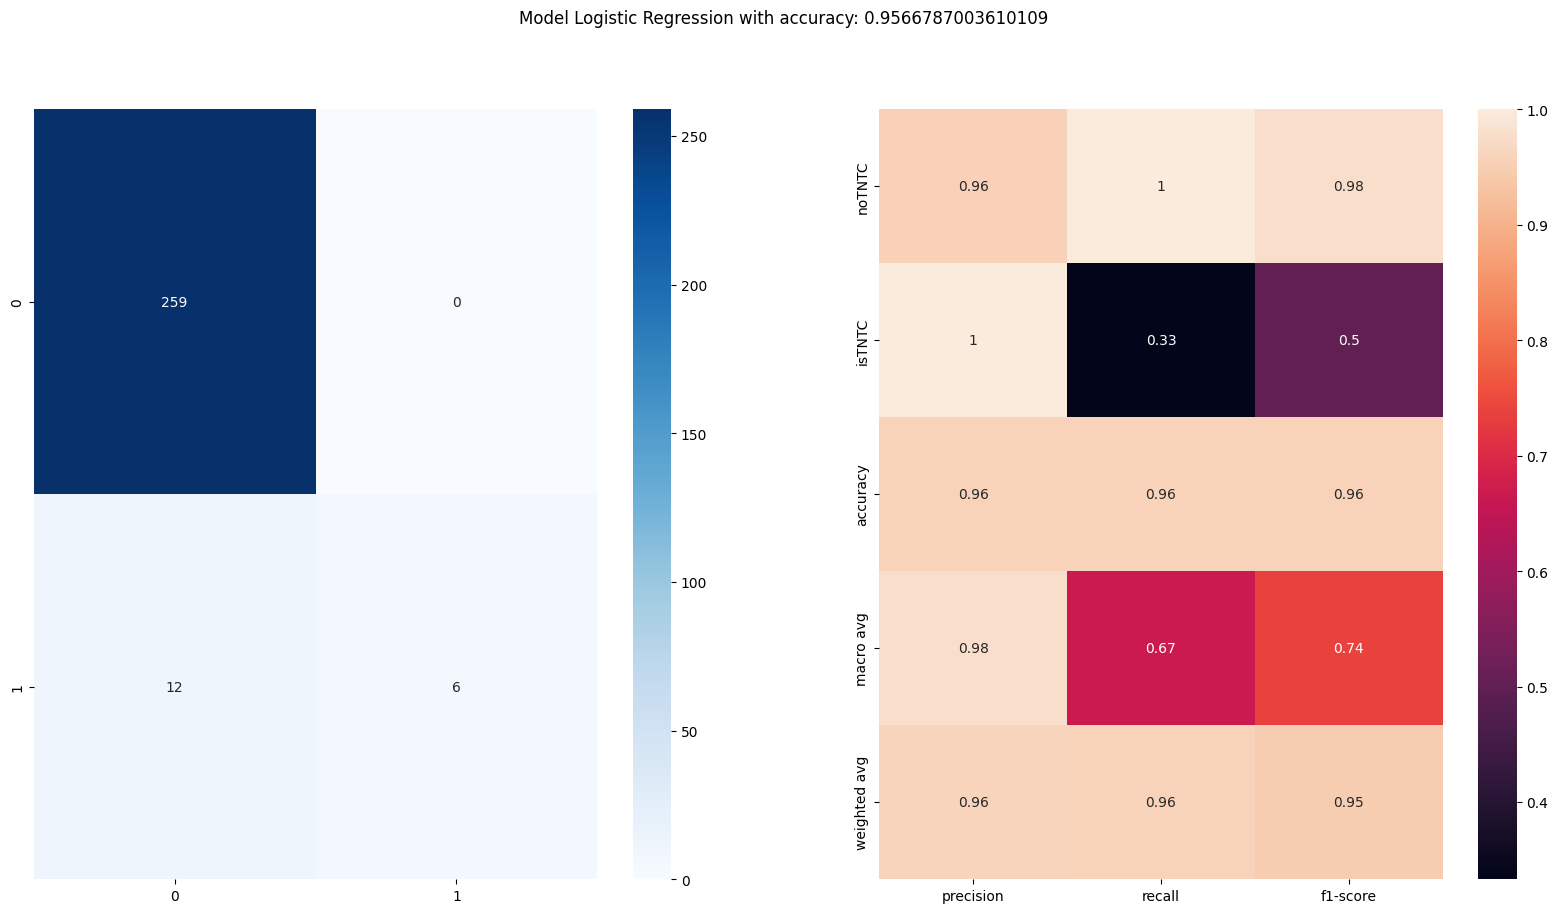

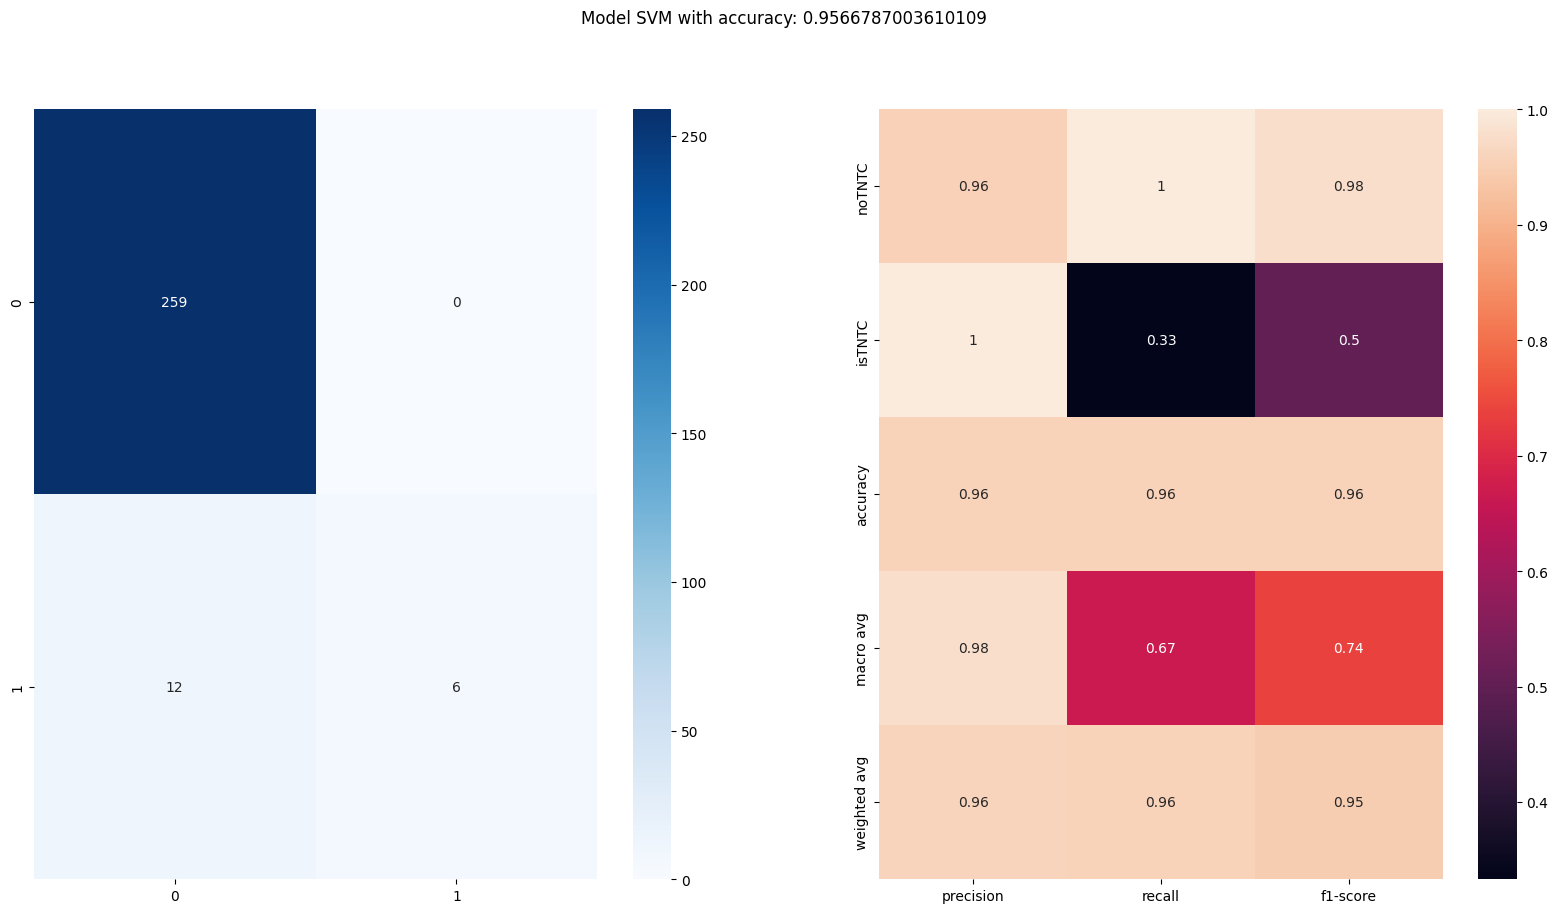

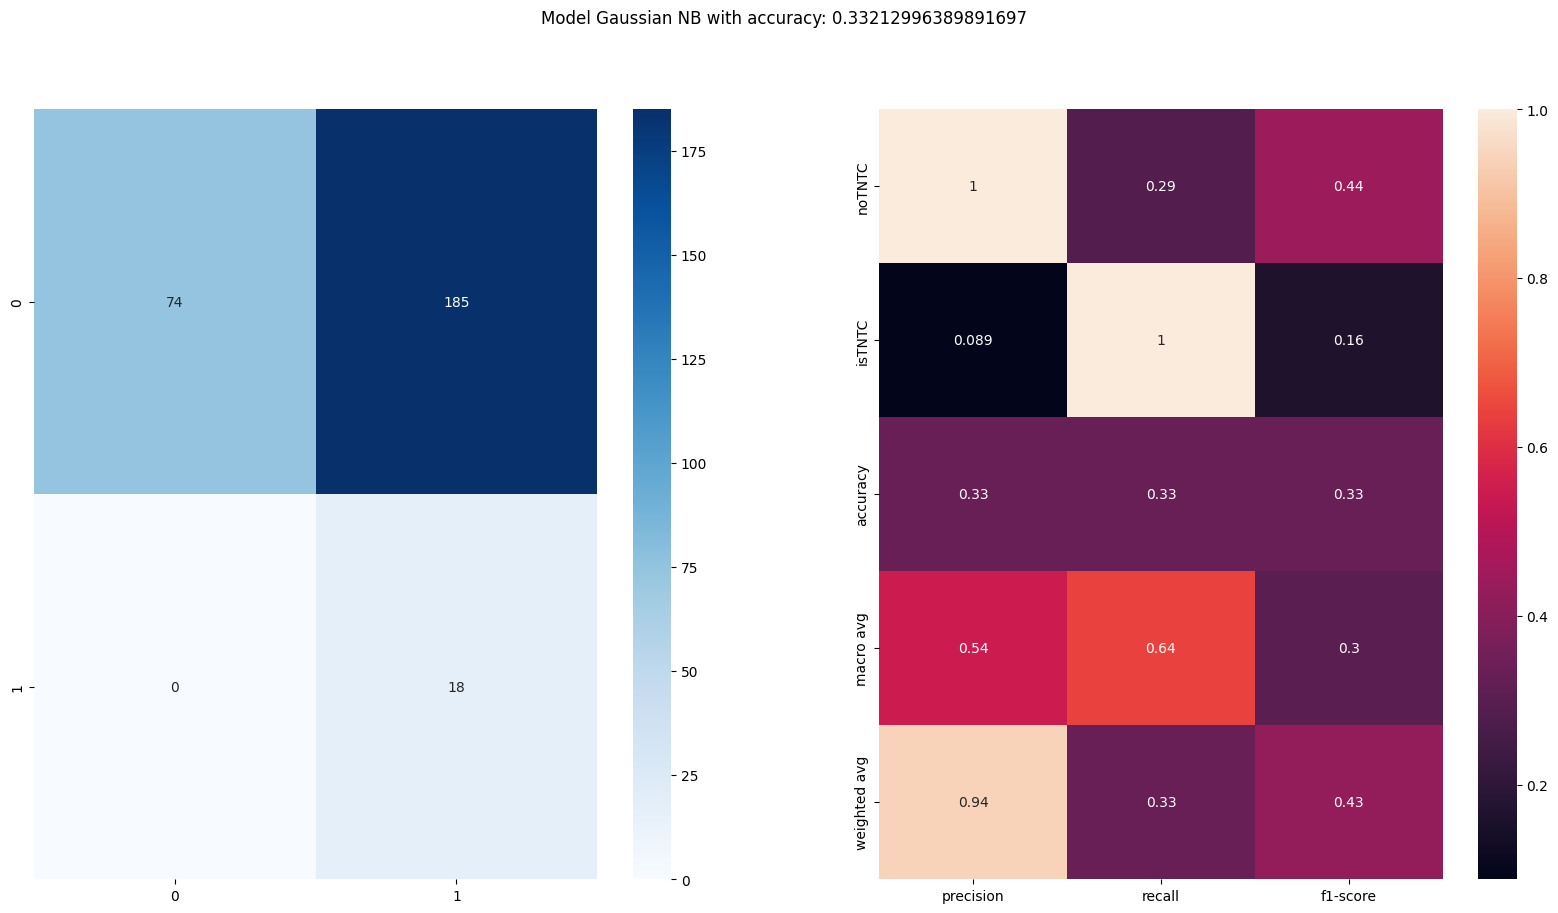

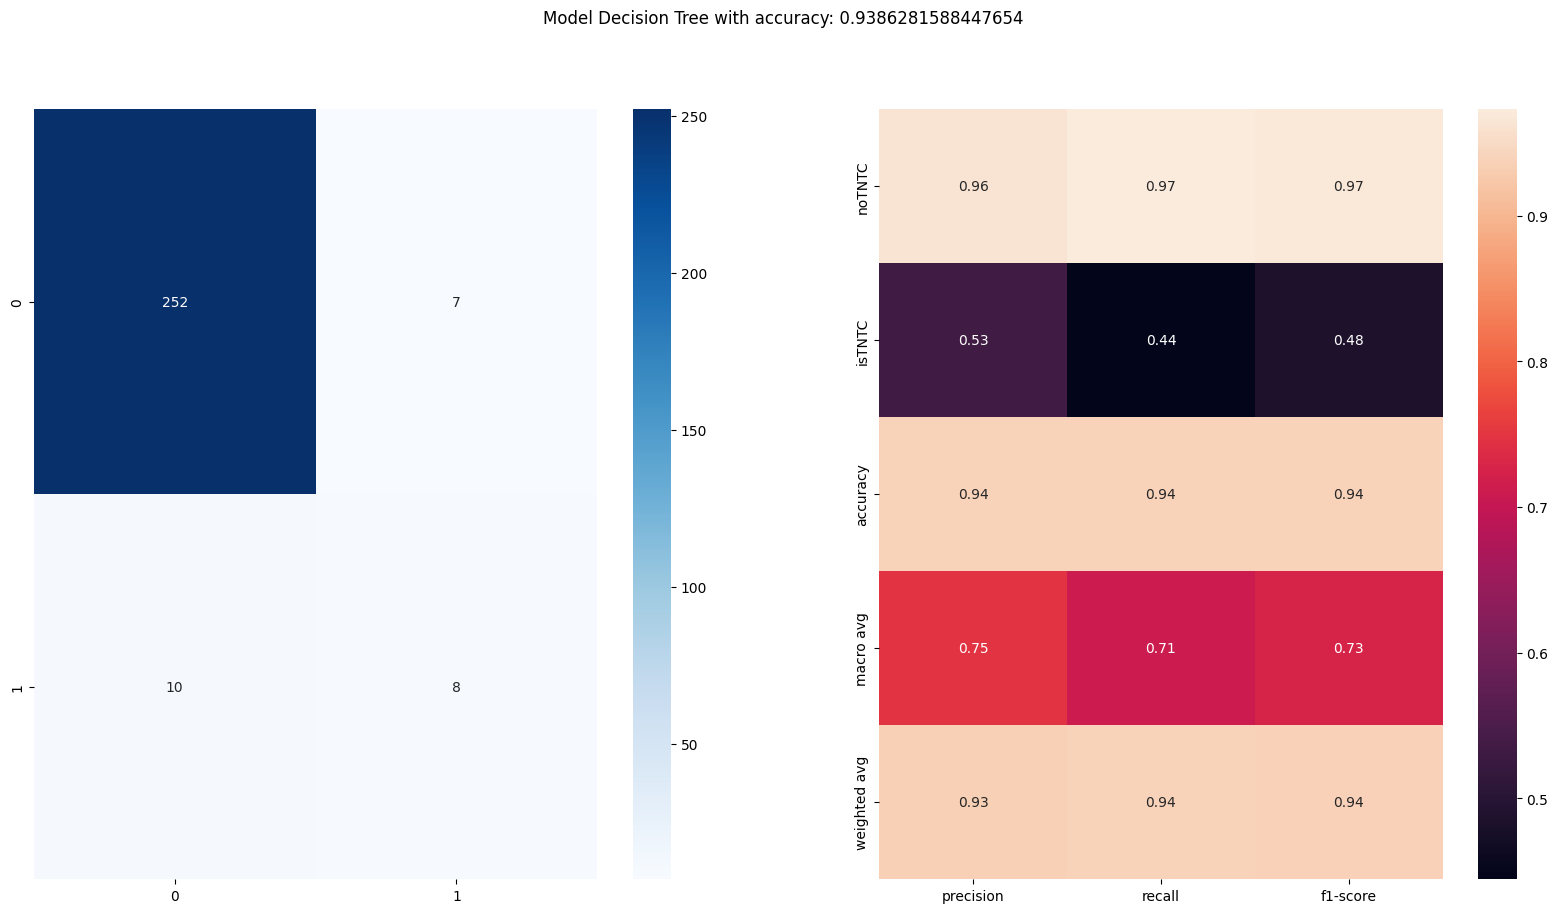

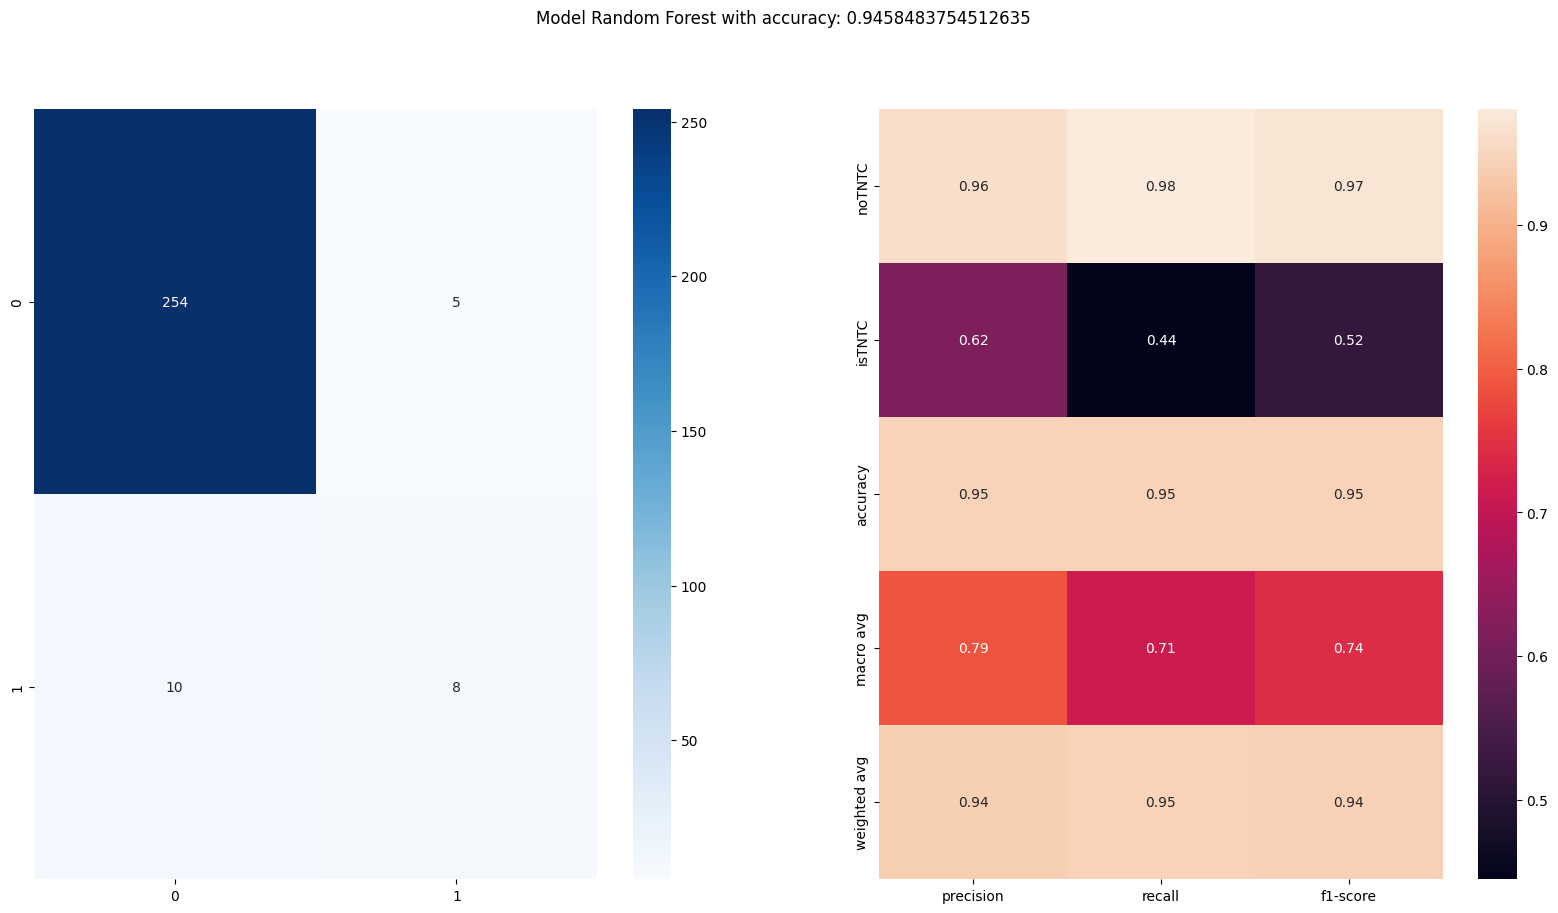

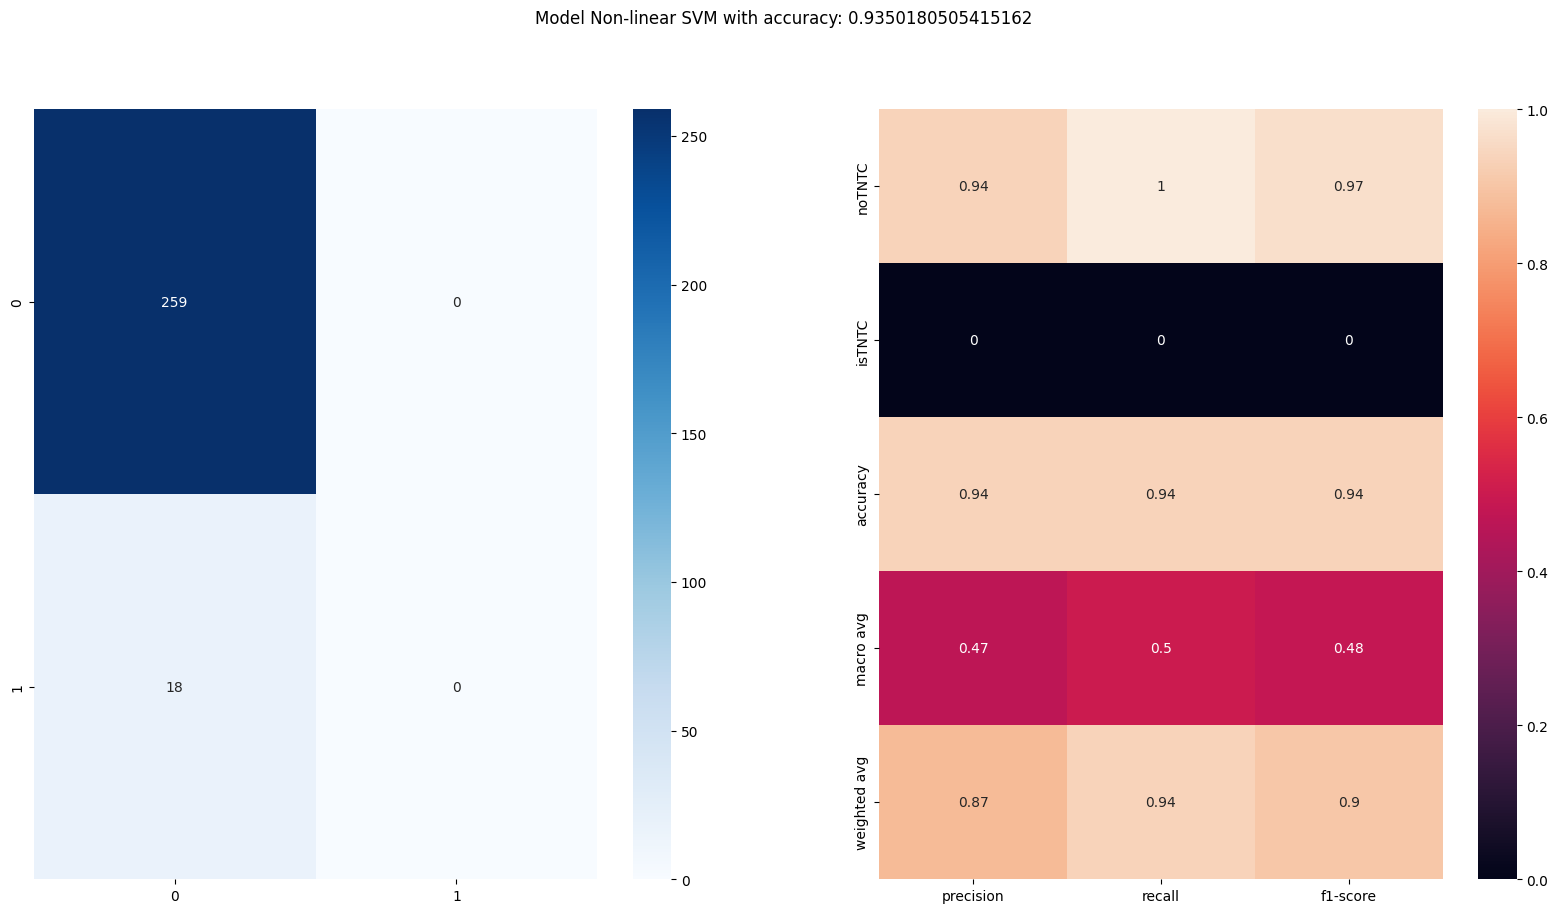

In [231]:
for method, result in results.items():
    fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
    sns.heatmap(
        result["confusion_matrix"], annot=True, cmap="Blues", fmt="g", ax=axs[0]
    )
    sns.heatmap(
        pd.DataFrame(result["classification_report"]).iloc[:-1, :].T,
        annot=True,
        ax=axs[1],
    )
    fig.suptitle(f"Model {method} with accuracy: {result['accuracy']}")

    plt.show()

# Coliform - Classification

In [46]:
class_coliform_df = coliform_df[
    ["Site", "Temp C_mean", "Ph_mean", "Cond (ms)_mean", "<=median"]
]

class_coliform_df["<=median"] = class_coliform_df["<=median"].astype("category")

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_8052/3200852975.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
for site in class_coliform_df["Site"].unique():
    fig = px.scatter_3d(
        class_coliform_df[class_coliform_df["Site"] == site],
        x="Temp C_mean",
        y="Ph_mean",
        z="Cond (ms)_mean",
        color="<=median",
    )
    fig.update_layout(
        title_text="Site: "
        + site
        + ", "
        + "Count: "
        + str(len(class_coliform_df[class_coliform_df["Site"] == site]))
        + ", "
        + "Median: "
        + str(coliform_df[coliform_df["Site"] == site]["median"].unique())
    )

    fig.add_annotation()
    fig.show()

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## Linear vs Non-Linear

In [48]:
class_coliform_df.drop(columns=["Site"], inplace=True)
class_coliform_df.dropna(inplace=True)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_8052/64996624.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_8052/64996624.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
X = class_coliform_df.drop(columns=["<=median"])
y = class_coliform_df["<=median"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, shuffle=True
)

### Linear Models

In [51]:
logreg = LogisticRegression()
linear_svm = svm.SVC(kernel="linear")

In [52]:
logreg.fit(X_train, y_train)
linear_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [53]:
logreg_pred = logreg.predict(X_test)
linear_svm_pred = linear_svm.predict(X_test)

#### Logistic Regression

In [54]:
cf_matrix = confusion_matrix(y_test, logreg_pred)
clf_report = classification_report(
    y_test,
    logreg_pred,
    labels=[0, 1],
    target_names=["Not TNTC", "TNTC"],
    output_dict=True,
)
acc_score = accuracy_score(y_test, logreg_pred)

<Axes: >

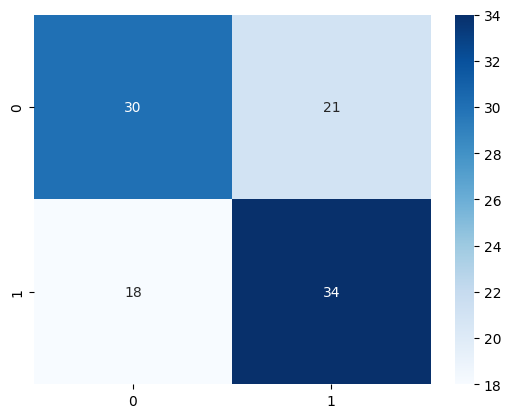

In [55]:
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

<Axes: >

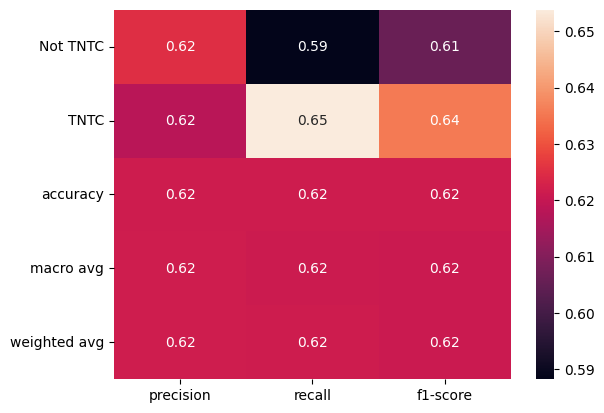

In [56]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [57]:
print("Accuracy: ", acc_score)

Accuracy:  0.6213592233009708


#### Linear SVM

In [58]:
cf_matrix = confusion_matrix(y_test, linear_svm_pred)
clf_report = classification_report(
    y_test,
    linear_svm_pred,
    labels=[0, 1],
    target_names=["Not TNTC", "TNTC"],
    output_dict=True,
)
acc_score = accuracy_score(y_test, linear_svm_pred)

<Axes: >

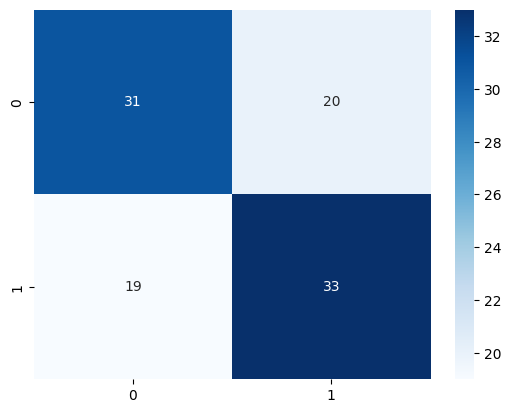

In [59]:
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

<Axes: >

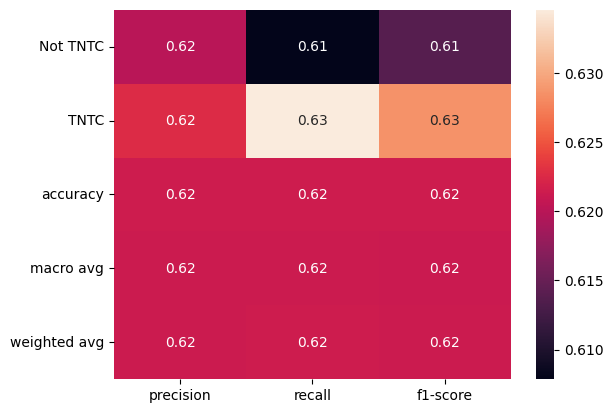

In [60]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [61]:
print("Accuracy: ", acc_score)

Accuracy:  0.6213592233009708


### Non-Linear Models

In [62]:
naive_bayes = GaussianNB()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
non_linear_svm = svm.SVC(kernel="rbf", gamma="scale")

In [63]:
naive_bayes.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
non_linear_svm.fit(X_train, y_train)

SVC()

In [64]:
naive_bayes_pred = naive_bayes.predict(X_test)
decision_tree_pred = decision_tree.predict(X_test)
random_forest_pred = random_forest.predict(X_test)
non_linear_svm_pred = non_linear_svm.predict(X_test)

#### Gaussian Naïve Bayes

In [65]:
cf_matrix = confusion_matrix(y_test, naive_bayes_pred)
clf_report = classification_report(
    y_test,
    naive_bayes_pred,
    labels=[0, 1],
    target_names=["Not TNTC", "TNTC"],
    output_dict=True,
)
acc_score = accuracy_score(y_test, naive_bayes_pred)

<Axes: >

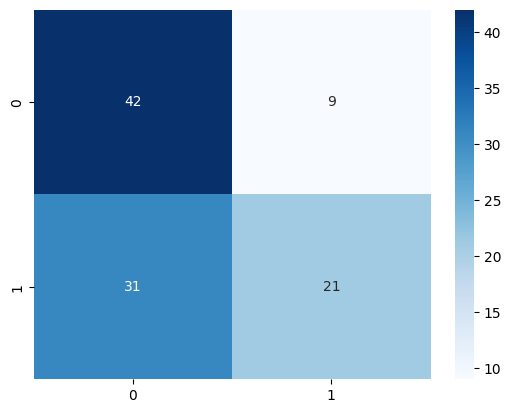

In [66]:
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

<Axes: >

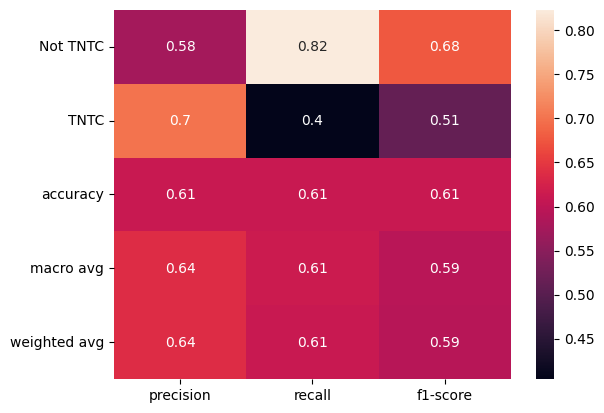

In [67]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [68]:
print("Accuracy: ", acc_score)

Accuracy:  0.6116504854368932


#### Decision Tree

In [69]:
cf_matrix = confusion_matrix(y_test, decision_tree_pred)
clf_report = classification_report(
    y_test,
    decision_tree_pred,
    labels=[0, 1],
    target_names=["Not TNTC", "TNTC"],
    output_dict=True,
)
acc_score = accuracy_score(y_test, decision_tree_pred)

<Axes: >

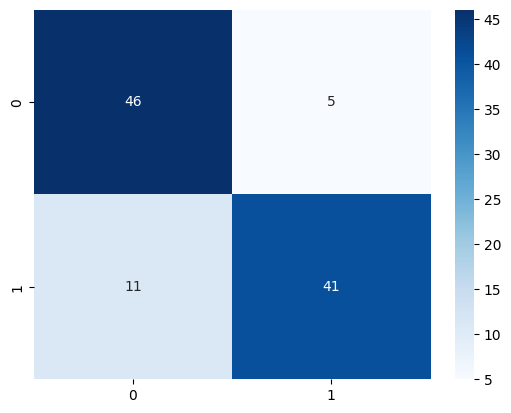

In [70]:
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

<Axes: >

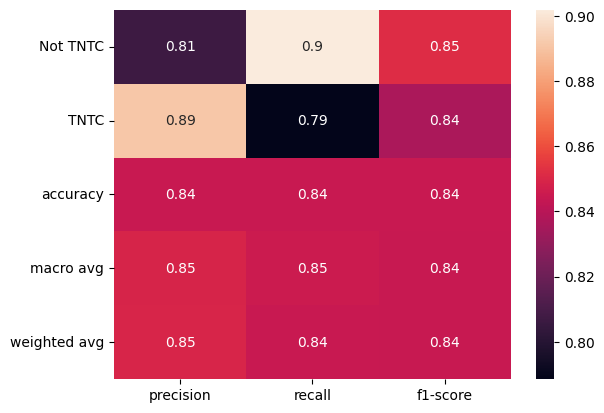

In [71]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [72]:
print("Accuracy: ", acc_score)

Accuracy:  0.8446601941747572


#### Random Forest

In [73]:
cf_matrix = confusion_matrix(y_test, random_forest_pred)
clf_report = classification_report(
    y_test,
    random_forest_pred,
    labels=[0, 1],
    target_names=["Not TNTC", "TNTC"],
    output_dict=True,
)
acc_score = accuracy_score(y_test, random_forest_pred)

<Axes: >

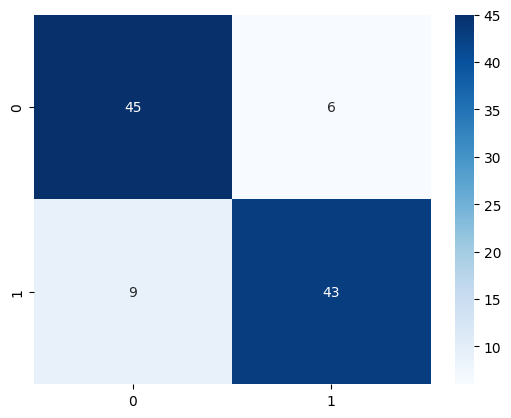

In [74]:
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

<Axes: >

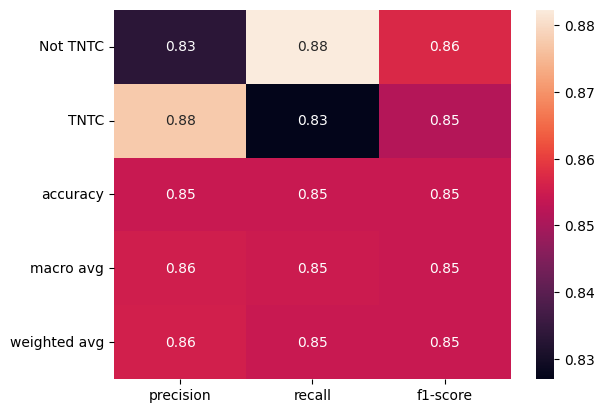

In [75]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [76]:
print("Accuracy: ", acc_score)

Accuracy:  0.8543689320388349


#### Non-Linear SVM

In [77]:
cf_matrix = confusion_matrix(y_test, non_linear_svm_pred)
clf_report = classification_report(
    y_test,
    non_linear_svm_pred,
    labels=[0, 1],
    target_names=["Not TNTC", "TNTC"],
    output_dict=True,
)
acc_score = accuracy_score(y_test, non_linear_svm_pred)

<Axes: >

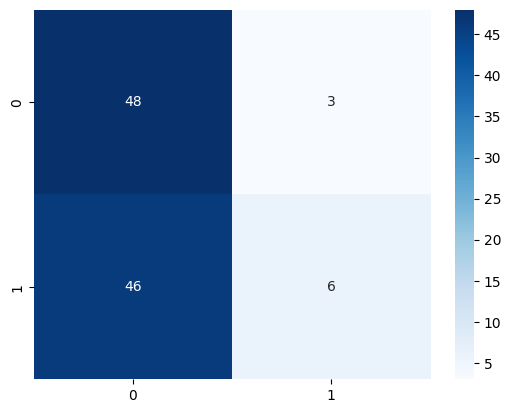

In [78]:
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

<Axes: >

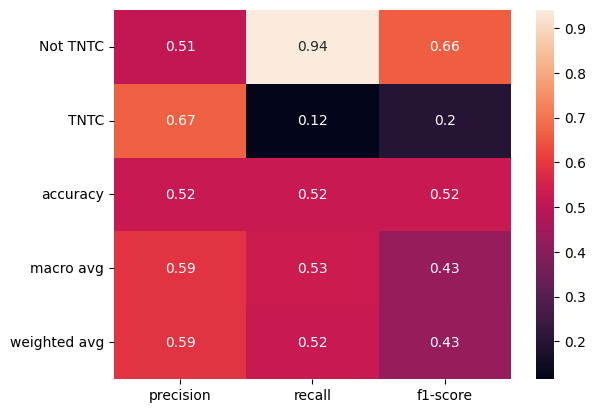

In [79]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [80]:
print("Accuracy: ", acc_score)

Accuracy:  0.5242718446601942


# Classifiers Comparison

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
X = class_coliform_df.drop(columns=["isTNTC"])
y = class_coliform_df["isTNTC"]

In [ ]:
logreg = LogisticRegression(random_state=42)
linear_svm = svm.SVC(kernel="linear", random_state=42)
naive_bayes = GaussianNB()
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
non_linear_svm = svm.SVC(kernel="rbf", gamma="scale", random_state=42)

In [ ]:
classifiers = [
    logreg,
    linear_svm,
    naive_bayes,
    decision_tree,
    random_forest,
    non_linear_svm,
]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
    print(clf.__class__.__name__, scores)

LogisticRegression [0. 0. 0. 0. 0.]
SVC [0. 0. 0. 0. 0.]
GaussianNB [0.         0.31818182 0.11428571 0.         0.25806452]
DecisionTreeClassifier [0.11428571 0.05714286 0.04761905 0.31578947 0.07407407]
RandomForestClassifier [0.15384615 0.06060606 0.05555556 0.45454545 0.08695652]
SVC [0. 0. 0. 0. 0.]


In [ ]:
from sklearn.utils import resample

In [ ]:
df_majority = class_coliform_df[class_coliform_df.isTNTC == 0]
df_minority = class_coliform_df[class_coliform_df.isTNTC == 1]

df_majority.shape, df_minority.shape

((257, 4), (62, 4))

In [ ]:
df_minority_upsampled = resample(
    df_minority, replace=True, n_samples=257, random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
X, y = df_upsampled.drop(columns=["isTNTC"]), df_upsampled["isTNTC"]

In [ ]:
logreg = LogisticRegression(random_state=42)
linear_svm = svm.SVC(kernel="linear", random_state=42)
naive_bayes = GaussianNB()
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
non_linear_svm = svm.SVC(kernel="rbf", gamma="scale", random_state=42)

In [ ]:
classifiers = [
    logreg,
    linear_svm,
    naive_bayes,
    decision_tree,
    random_forest,
    non_linear_svm,
]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
    print(clf.__class__.__name__, scores.mean())

LogisticRegression 0.5269403386957376
SVC 0.5295999632850972
GaussianNB 0.6664370436030559
DecisionTreeClassifier 0.8384704726168142
RandomForestClassifier 0.8324169589398235
SVC 0.6648892687740923
